In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tabulate import tabulate
from feature_engine.selection import DropCorrelatedFeatures,SmartCorrelatedSelection
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("train.csv")

In [3]:
print(df.shape)

(76020, 371)


In [4]:
df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


#### Before starting I will do the following:
1. Drop the 'ID' column as this not useful for analysis

In [5]:
df = df.drop(["ID"], axis=1)
X = df.drop(["TARGET"], axis=1)
y_t = df.TARGET

In [6]:
class_0, class_1 = df.TARGET.value_counts()
print(f"We have total {class_0} observations in Class 0 or Majority Class or Satisfied Customers")
print(f"We have total {class_1}  observations in Class 1 or Minority Class or UnSatisfied Customers")

We have total 73012 observations in Class 0 or Majority Class or Satisfied Customers
We have total 3008  observations in Class 1 or Minority Class or UnSatisfied Customers


In [7]:
total_obs = class_0 + class_1
min_per = round(class_1/total_obs * 100,0)
maj_per = round(class_0/total_obs * 100,0)
print(f"Of the total percentage of observations, {min_per}% of customers are UnSatisfied and {maj_per}% of customers are Satisfied customers.")

Of the total percentage of observations, 4.0% of customers are UnSatisfied and 96.0% of customers are Satisfied customers.


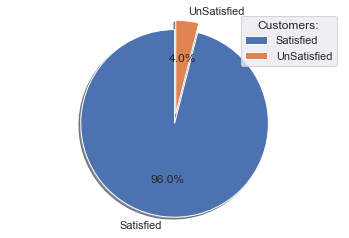

In [8]:
customers = ['Satisfied', 'UnSatisfied']
data = [class_0, class_1]
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(data, explode=explode, labels=customers, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(title='Customers:')
plt.show()

###### CONCLUSION: The dataset is highly imbalanced

In [9]:
df.TARGET=['Satisfied' if i==0 else 'Unsatisfied' for i in df.TARGET]  
## replacing the 'TARGET' feature with satisfied or unsatisfied instead of 0 and 1

# Exploratory Data Analysis and Feature Engineering

The data seems to very sparse. In such cases number of non zero and zero values may carry additional information, especially since the TARGET variable is related to customer satisfaction. We will count how many of those features we have in the dataset (by row).

In [10]:
num_of_zeros = (X == 0).astype(int).sum(axis=1)  ## take sum of all features which have 0 by row
num_of_non_zeros = (X != 0).astype(int).sum(axis=1)  ## take sum of all features which are not 0 by row

# create two new features
X['nmbr_of_zeros'] = num_of_zeros
X['nmbr_of_non_zeros'] = num_of_non_zeros

If we look at the names of the features it doesn't provide us any useful insights as they are anonymized. But we can see that the column names consist of keywords like <b>imp</b>, <b>ind</b>, <b>num</b> and <b>saldo</b>. <br>
There are total 5 features which dont have these keywords.

In [11]:
for i in X.columns:
    flag=0
    for j in ['imp', 'ind', 'num', 'saldo']:
        if j in i:
            flag=1
            break
    if flag==0:
        print(i)

var3
var15
var36
var21
var38
nmbr_of_zeros
nmbr_of_non_zeros


We will begin the EDA on these 5 features first

In [12]:
def dist_in_each_class(data, col_name):
    """
    This function prints the percentage of the value of that feature that we have in different classes
    """
    print('*'*50)
    print('For Satisfied Customers:')
    print('------------------------')
    col_name_satisfied = dict(data[col_name][df['TARGET']=='Satisfied'].value_counts())
    for i in col_name_satisfied:
        print(f'{i} = {round(col_name_satisfied[i]/class_0 *100,2)}% of total Satisfied Customers')
    print('*'*50)
    print('For Unsatisfied Customers:')
    print('--------------------------')
    col_name_unsatisfied = dict(data[col_name][df['TARGET']=='Unsatisfied'].value_counts())
    for i in col_name_unsatisfied:
        print(f'{i} = {round(col_name_unsatisfied[i]/class_1 *100,2)}% of total Unsatisfied Customers')
    print('*'*50)

### 1. var3

If we look at the value count of var3 variable we can see that it contains a value -999999 for 116 datapoints

In [13]:
X.var3.value_counts()  ## to my assumption the value -999999 might be a NaN which was imputed as -999999

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

If we focus only on the <b>116</b> datapoints for where var3 was -999999

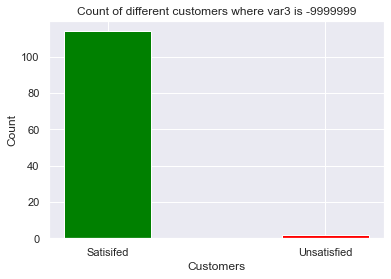

1.72% of the 116 datapoints are 1(or unsatisfied), which is lower than that average of 4% we found earlier.
Hence dropping these rows where var3= -999999 is not suggested.
The better approach would be to replace it with the 'Mode' of var3 feature.


In [14]:
satisfied_var3, unsatisfied_var3 = df[df['var3']==-999999]['TARGET'].value_counts()
plt.bar(['Satisifed','Unsatisfied'], [satisfied_var3,unsatisfied_var3],width = 0.4,color=['Green', 'Red'])
plt.xlabel("Customers")
plt.ylabel("Count")
plt.title("Count of different customers where var3 is -9999999")
plt.show()
print(f'{round(unsatisfied_var3/116 * 100,2)}% of the 116 datapoints are 1(or unsatisfied), which is lower than that average of 4% we found earlier.\nHence dropping these rows where var3= -999999 is not suggested.')
print('The better approach would be to replace it with the \'Mode\' of var3 feature.')

In [15]:
print(X.var3[X.var3 != -999999].min())
print(X.var3[X.var3 != -999999].max())
## If I remove rows where the value is -999999, the minimum and maximum value for 'var3' feature comes to be 0 and 238 
## hence -999999 can be considered as outlier and be replaced by with the maximum occuring value ie '2' in case for 'var3'

0
238


In [16]:
X = X.replace(to_replace=-999999, value=2)
X.var3.value_counts()

2      74281
8        138
9        110
3        108
1        105
       ...  
231        1
188        1
168        1
135        1
87         1
Name: var3, Length: 207, dtype: int64

Next we can check if the distribution of var3 feature where its value equal to '2' and also when its value is not equal to '2'.

In [17]:
def annotate_countplt(df_new):
    total = len(df_new)
    ax = sns.countplot(df_new['TARGET'])
    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()/2
        ax.text(p.get_x()+width,height,'{:.2f}%'.format(height*100/total),ha="center") 

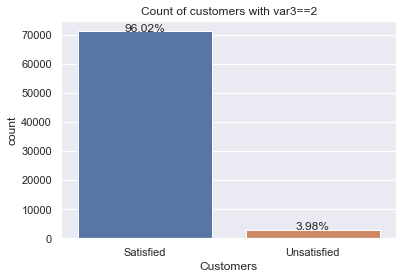

In [18]:
df_var3_eq2 = df[ df['var3']==2 ]
annotate_countplt(df_var3_eq2)
plt.title("Count of customers with var3==2")
plt.xlabel('Customers')
plt.show()

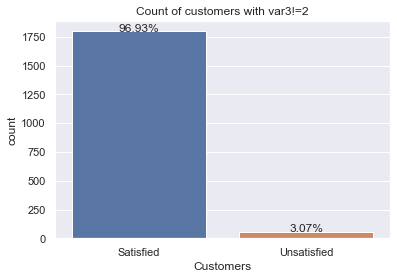

In [19]:
df_var3_eq2 = df[ df['var3']!=2 ]
annotate_countplt(df_var3_eq2)
plt.title("Count of customers with var3!=2")
plt.xlabel('Customers')
plt.show()

we can be confirm here that var3's count distribution when its value is 2 and when its not 2 is similar with approx 96% in satisfied customers and 4% is unsatisfied customers.

### 2. var15

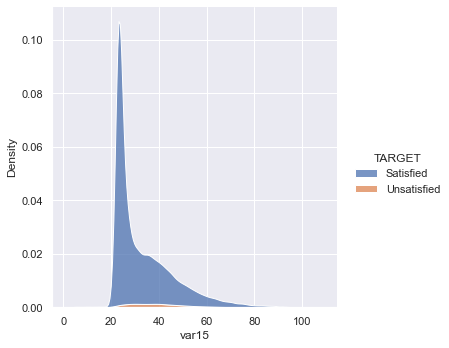

In [20]:
sns.displot(data=df, 
            x="var15", 
            hue="TARGET", 
            kind="kde",
            multiple="stack"
           )

We can see that there is a spike in the value for var15 between the value of 20 and 30.<br>
Lets investigate this further.

In [21]:
df.var15.value_counts().head(10)  ## we can see the top 10 values 

23    20170
24     6232
25     4217
26     3270
27     2861
28     2173
31     1798
29     1727
30     1640
32     1592
Name: var15, dtype: int64

It is evident to us that the var15 variable's spike was at value '23', which contains the highest records.
<br> But what does this variable var15 actually represent. To check that lets find the range (min and max) of var15.

In [22]:
print(f'Minimum value of var15 feature is {min(df.var15)} and Maximum value is {max(df.var15)}')

Minimum value of var15 feature is 5 and Maximum value is 105


This range gives me a feeling that var15 could represent <b>age</b> as it is falling in a given range of human expectancy of age.

In [23]:
min(df[df['TARGET']=='Unsatisfied'].var15.value_counts().index) 
## this value here represents that for Unsatisfied customers the minimum value of var15 is 23.

23

Looking at the above information we can also conclude that below the value of 23 all the customers are Satisfied.<br>
This can be used for feature engineering in future, other than this the var15 is not that helpful in seperating satisfied and unsatisfied customers

###### Looking as seperate histogram of var15 for satisfied and usnsatisfied customers

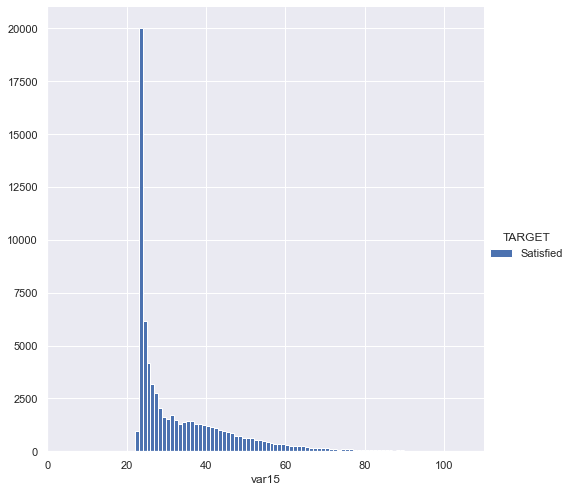

In [24]:
sns.FacetGrid(data=df[df['TARGET']=='Satisfied'],hue='TARGET',height=7).map(plt.hist,'var15',bins=100).add_legend()
plt.show()

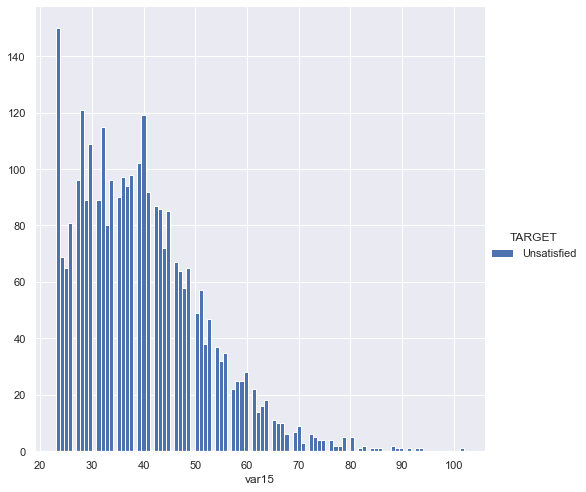

In [25]:
sns.FacetGrid(data=df[df['TARGET']=='Unsatisfied'],hue='TARGET',height=7).map(plt.hist,'var15',bins=100).add_legend()
plt.show()

<AxesSubplot:xlabel='TARGET', ylabel='var15'>

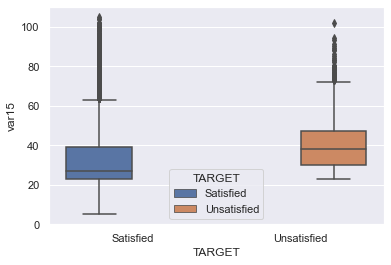

In [26]:
sns.boxplot(x='TARGET', y='var15', hue='TARGET', data=df)  
## we can check the boxplot of var15 to get where the median, 25th, 75th percentile and IQR falls

### 3. var36

In [27]:
df.var36.value_counts()
## cardinality of var36 is simpler than var3 and var15 with only 4 distinct values

99    30064
3     22177
1     14664
2      8704
0       411
Name: var36, dtype: int64

Text(0.5, 1.0, 'frequency plot for var36 for different customers')

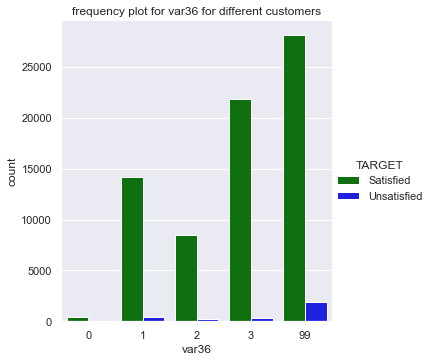

In [28]:
## looking at the frequency plot for var36 for different customers
sns.catplot("var36", hue="TARGET", data=df, kind="count", 
            palette={"Unsatisfied":"blue", "Satisfied":"green"})
plt.title('frequency plot for var36 for different customers')

##### If we check the percentage of each of the 5 different values for var36 for different TARGET value we get the below result:

In [29]:
dist_in_each_class(df, 'var36')

**************************************************
For Satisfied Customers:
------------------------
99 = 38.52% of total Satisfied Customers
3 = 29.87% of total Satisfied Customers
1 = 19.45% of total Satisfied Customers
2 = 11.59% of total Satisfied Customers
0 = 0.56% of total Satisfied Customers
**************************************************
For Unsatisfied Customers:
--------------------------
99 = 64.43% of total Unsatisfied Customers
1 = 15.33% of total Unsatisfied Customers
3 = 12.23% of total Unsatisfied Customers
2 = 8.01% of total Unsatisfied Customers
**************************************************


<b>Some interesting conclusions:</b><br>
    1. the value '0' for var36 is only present for satisfied customers and are missing for unsatisfied customers(This can be used for feature engineering).<br>
    2. About 64% of the Unsatisfied customers have 99 as value for var36 compared to the 39% in Satisfied customers. Hence it might be useful information and should not be dropped.
    3. the value 99 seems as an outlier

We will try to handle handle this outlier of 99 in var36 using <b>KNNImputer</b> 
Reference for the code from: https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/

In [30]:
from sklearn.impute import KNNImputer
temp_df_var36=pd.DataFrame(df.var36)
temp_df_var36=temp_df_var36.replace({99:np.NaN})
imputer = KNNImputer(n_neighbors=10)
imputed_data = imputer.fit_transform(temp_df_var36)
df_temp = pd.DataFrame(imputed_data)
df_temp.value_counts()

2.145596    30064
3.000000    22177
1.000000    14664
2.000000     8704
0.000000      411
dtype: int64

It can be seen that the imputer tried to replace 99 with 2.14 using the 10 nearest neighbors. Rounding this 2.14 to 2 we will replace all 99 in var36 with value 2.

In [31]:
X.var36=X.var36.replace(to_replace=99, value=2)

In [32]:
tmp_df_var36=df[['var36','TARGET']]
a=tmp_df_var36.var36.replace(to_replace=99, value=2)
tmp_df_var36['var36'] = a

C:\Users\ud231\AppData\Local\Temp/ipykernel_17372/4171323659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df_var36['var36'] = a


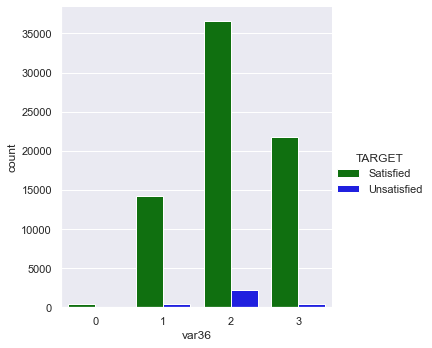

In [33]:
## looking at the frequency plot for var36 for different customers
sns.catplot("var36", hue="TARGET", data=tmp_df_var36, kind="count", 
            palette={"Unsatisfied":"blue", "Satisfied":"green"})

### 4. var21

In [34]:
df.var21.value_counts()  ## This feature has 98.8% data of the total obervations as 0

0        75152
900        236
1800       206
4500        96
3000        84
7200        62
3600        52
1500        31
6000        27
2700        26
9000        14
1200        12
5400         4
2400         3
18000        2
3300         2
4200         2
5100         2
2100         2
5700         1
10500        1
6600         1
7500         1
30000        1
Name: var21, dtype: int64

Next we can check the percentage of distribution in each different class.

In [35]:
dist_in_each_class(df, 'var21')

**************************************************
For Satisfied Customers:
------------------------
0 = 98.86% of total Satisfied Customers
900 = 0.31% of total Satisfied Customers
1800 = 0.26% of total Satisfied Customers
4500 = 0.13% of total Satisfied Customers
3000 = 0.11% of total Satisfied Customers
7200 = 0.08% of total Satisfied Customers
3600 = 0.07% of total Satisfied Customers
1500 = 0.04% of total Satisfied Customers
6000 = 0.04% of total Satisfied Customers
2700 = 0.04% of total Satisfied Customers
9000 = 0.02% of total Satisfied Customers
1200 = 0.01% of total Satisfied Customers
5400 = 0.01% of total Satisfied Customers
2400 = 0.0% of total Satisfied Customers
3300 = 0.0% of total Satisfied Customers
5100 = 0.0% of total Satisfied Customers
18000 = 0.0% of total Satisfied Customers
5700 = 0.0% of total Satisfied Customers
30000 = 0.0% of total Satisfied Customers
4200 = 0.0% of total Satisfied Customers
10500 = 0.0% of total Satisfied Customers
6600 = 0.0% of total Sati

<b>Observation:</b><br>
1. In both Satisfied customers and Unsatisfied customers the percentage of value '0' is same of about 98.8% for each class.<br>
2. Apart from '0' we have '1800', '900', '3000' and '4500' which have percentage greater than 0.1% in each class.<br>
3. Rest have percentage less than 0.1% in each class, and can be encoded to single group.

Conclusion, as this feature have 98.8% of total observation with same value, we can maybe encode it to have categories such as '0' and others.

### 5. var38

In [36]:
df.var38.value_counts()  ## The mode of the value of feature var38 is 117310.979016494

117310.979016    14868
451931.220000       16
463625.160000       12
288997.440000       11
104563.800000       11
                 ...  
89665.500000         1
45876.570000         1
151505.640000        1
74548.170000         1
84278.160000         1
Name: var38, Length: 57736, dtype: int64

If I <b>remove the mode value of var38</b> ie 117310.979016494, below is the mean, median, min and max value of the remaining datapoints

In [37]:
print(f'mean {df[df["var38"]!=117310.979016494].var38.mean()}')
print(f'median {df[df["var38"]!=117310.979016494].var38.median()}')
print(f'min {df[df["var38"]!=117310.979016494].var38.min()}')
print(f'max {df[df["var38"]!=117310.979016494].var38.max()}')

mean 117217.53330847724
median 88901.94
min 5163.75
max 22034738.76


Observation: The mean of the remaining values after removing the mode value is more or less close to the mode value

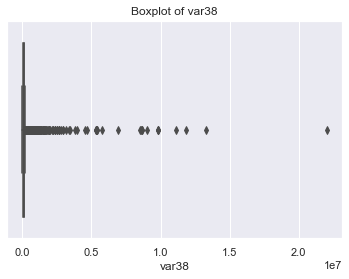

In [38]:
sns.boxplot(x=df.var38) ## plot a boxplot to see the value range
plt.title("Boxplot of var38")
plt.show()

Not much insights could be found with this boxplot other than this that there are many extreme values present in the var38

In [39]:
def percentile_table(a,b,c,vals):
    from tabulate import tabulate
    percentile=[]
    percen_values=[]
    for i in np.arange(a,b,c):
        a=str(round(i,1))
        percentile.append([a+'th',round(np.percentile(vals,i),2)])
    print(tabulate(percentile, headers=['Percentiles','Values'], tablefmt="pretty"))

In [40]:
percentile_table(0,110,10,df.var38.values)

+-------------+-------------+
| Percentiles |   Values    |
+-------------+-------------+
|     0th     |   5163.75   |
|    10th     |  48070.59   |
|    20th     |  61496.92   |
|    30th     |  74152.06   |
|    40th     |  88571.67   |
|    50th     |  106409.16  |
|    60th     |  117310.98  |
|    70th     |  117310.98  |
|    80th     |  132859.34  |
|    90th     |  182585.92  |
|    100th    | 22034738.76 |
+-------------+-------------+


We can see that there is significant jump in 0th to 10th percentile and also from 90th to 100th percentile

In [41]:
## lets see the percentile from 0th to 10th
percentile_table(0,11,1,df.var38.values)

+-------------+----------+
| Percentiles |  Values  |
+-------------+----------+
|     0th     | 5163.75  |
|     1th     | 25587.62 |
|     2th     | 30736.16 |
|     3th     | 34227.31 |
|     4th     | 36950.6  |
|     5th     | 39255.76 |
|     6th     | 41355.33 |
|     7th     | 43233.16 |
|     8th     | 44913.17 |
|     9th     | 46474.38 |
|    10th     | 48070.59 |
+-------------+----------+


In [42]:
## lets see the percentile from 90th to 100th
percentile_table(90,101,1,df.var38.values)

+-------------+-------------+
| Percentiles |   Values    |
+-------------+-------------+
|    90th     |  182585.92  |
|    91th     |  191244.15  |
|    92th     |  200948.93  |
|    93th     |  212239.21  |
|    94th     |  225878.28  |
|    95th     |  242780.16  |
|    96th     |  265251.85  |
|    97th     |  298814.36  |
|    98th     |  353727.78  |
|    99th     |  457674.14  |
|    100th    | 22034738.76 |
+-------------+-------------+


Here there is still significant bump from 99th to 100th percentile

In [43]:
## lets see the percentile from 99th to 100th
percentile_table(99,100.1,0.1,df.var38.values)

+-------------+-------------+
| Percentiles |   Values    |
+-------------+-------------+
|   99.0th    |  457674.14  |
|   99.1th    |  476448.43  |
|   99.2th    |  497629.66  |
|   99.3th    |  519232.4   |
|   99.4th    |  552757.98  |
|   99.5th    |  604430.5   |
|   99.6th    |  668340.69  |
|   99.7th    |  761927.4   |
|   99.8th    |  921784.57  |
|   99.9th    | 1227625.95  |
|   100.0th   | 22034738.76 |
+-------------+-------------+


Taking all the values below the 99.8 percentile we get the below histogram:

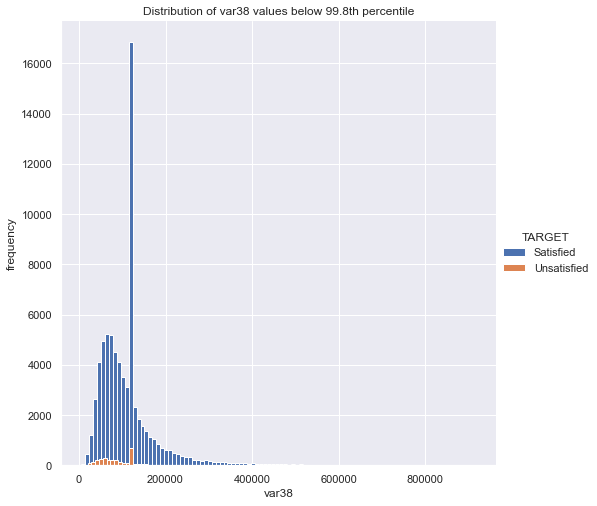

In [44]:
sns.FacetGrid(data=df[df['var38']<=921784.57],hue='TARGET',height=7).map(plt.hist,'var38',bins=100).add_legend()
plt.title('Distribution of var38 values below 99.8th percentile')
plt.ylabel("frequency")
plt.show()

We can definitely see a spike for the mode value of 117310.979016494, and also the plot has long tail in the right, making the plot similar to a log normal distribution. <br>
<b> What if I remove the mode value and take a log on the value and see what the plot looks like</b>

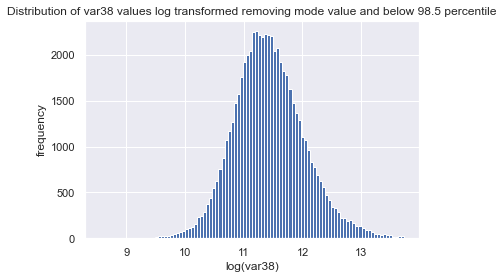

In [45]:
plt.hist(np.log(df.var38[df.var38!=117310.979016494][df.var38<=921784.57]),100)
plt.title("Distribution of var38 values log transformed removing mode value and below 98.5 percentile")
plt.xlabel('log(var38)')
plt.ylabel("frequency")
plt.show()

This looks like a perfect Gaussian distribution. The shape of the distribution suggests that this might be net worth, or income of customer or other measure of money value.

<b>So, in feature engineering, I'll replace the var38 value with log of the value. For now we can look at the final plot with both classes after taking log.</b>

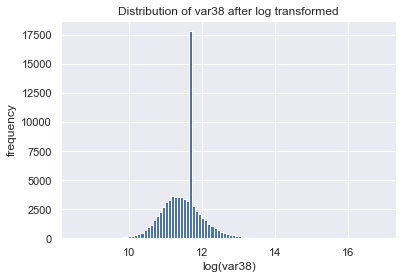

In [46]:
plt.hist(np.log(df.var38),100)
plt.title("Distribution of var38 after log transformed")
plt.xlabel('log(var38)')
plt.ylabel("frequency")
plt.show()

# Feature Engineering

### 1. Check if we have null values

In [47]:
X.isnull().any().any()

False

CONCLUSION: We don't have any NULL value in the dataset

### 2. Constant Features

As the name suggests these are those variables which constant value in the whole feature.

In [48]:
constant_features = X.nunique()[X.nunique()==1].index.to_list()
print(constant_features)  ## all these features have constant value, and can be removed
print()
print(f"We have {len(constant_features)} features which have constant value.")

['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']

We have 34 features which have constant value.


In [49]:
X = X.drop(constant_features, axis=1) ## drop the constant value features
print(f"New shape after removing these features {X.shape}")

New shape after removing these features (76020, 337)


### 3. Duplicate or same features

In [50]:
new_cols=X.columns
same_vals=[]
same_value_pairs=[]
for i in new_cols:  ## loop over columns
    for j in new_cols:  ## loop over columns
        if i!=j:  ## proceed only if the name of the two columns are not same
            if (i not in same_vals) and (j not in same_vals):  ## check if the columns are not already processed
                flag=0  ## set indicator flag to 0
                for t1,t2 in zip(X[i],X[j]):  ## loop of values of both columns one by one
                    if t1!=t2:  ## check if at any time value is different for any datapoint then exit
                        flag=1  ## set indicator to 1 and break the loop
                        break
                if flag==0:  ## if indicator is 0 means column are same
                    same_value_pairs.append((i,j))  ## store the columns which have same values
                    same_vals.append(i)  #store only a feature one

In [51]:
print("These are the feature pairs are actually duplicate of each other.\n")
print(tabulate(same_value_pairs, headers=['Feature_1','Feature_2'], tablefmt="pretty"))
print(f"\nThere are total {len(same_value_pairs)} such pairs")

These are the feature pairs are actually duplicate of each other.

+-------------------------------+-------------------------------+
|           Feature_1           |           Feature_2           |
+-------------------------------+-------------------------------+
|          ind_var6_0           |          ind_var29_0          |
|           ind_var6            |           ind_var29           |
|       ind_var13_medio_0       |        ind_var13_medio        |
|          ind_var18_0          |           ind_var18           |
|          ind_var26_0          |           ind_var26           |
|          ind_var25_0          |           ind_var25           |
|          ind_var32_0          |           ind_var32           |
|          ind_var34_0          |           ind_var34           |
|          ind_var37_0          |           ind_var37           |
|           ind_var40           |           ind_var39           |
|          num_var6_0           |          num_var29_0          |
|        

In [52]:
X = X.drop(same_vals, axis=1) ## drop the constant value features
print(f"New shape after removing these features {X.shape}")

New shape after removing these features (76020, 308)


### 4. Quasi constant features

Quasi-constant features, as the name suggests, are the features that are almost constant. In other words, these features have the same values for a very large subset of the outputs. Such features are not very useful for making predictions

In [53]:
def quasi_const(data, col):
    """
    Input:
        -data: Stores the dataset
        -col.: Stores the feature we want to check
    Output:
        -True: if the feature is quasi constant
        -False: if feature is not quasi constant
    Description:
        -The function finds if the feature has any value which is same for more than 99% of total observations
    """
    tot_rows = len(data[col])  ## find total observations for the feature
    vals = data[col].value_counts().index  ## get all different values of this feature
    for val in vals:  ## loop over those values
        num = len(data[col][data[col]==val])  ## count of observations where the value matches
        const_per = round(num/tot_rows * 100,2)  ## get the percentage of that value in total observation
        if const_per > 99:  ## check if percentage is greater than 99%
            return True  
    return False  ## when no value is more than 99% dominant

In [54]:
quasi_const_feature = []  ## list to store the quasi constant variables
for column in X.columns:  ## loop over all the columns we have
    if quasi_const(X, column):  ## check if the feature send to the function is quasi constant or not
        quasi_const_feature.append(column)  ## if true then add the feature in list
print(quasi_const_feature)

['imp_op_var40_comer_ult1', 'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1', 'imp_op_var40_efect_ult3', 'imp_op_var40_ult1', 'imp_sal_var16_ult1', 'ind_var1', 'ind_var13_medio', 'ind_var14', 'ind_var17_0', 'ind_var17', 'ind_var18', 'ind_var19', 'ind_var20_0', 'ind_var20', 'ind_var29_0', 'ind_var29', 'ind_var30_0', 'ind_var31_0', 'ind_var31', 'ind_var32_cte', 'ind_var32', 'ind_var33_0', 'ind_var33', 'ind_var34', 'ind_var39', 'ind_var44_0', 'ind_var44', 'num_var1', 'num_var13_medio', 'num_var14', 'num_var17_0', 'num_var17', 'num_var18', 'num_var20_0', 'num_var20', 'num_op_var40_hace2', 'num_op_var40_hace3', 'num_op_var40_ult1', 'num_op_var40_ult3', 'num_var29_0', 'num_var29', 'num_var31_0', 'num_var31', 'num_var32', 'num_var33_0', 'num_var33', 'num_var34', 'num_var39', 'num_var44_0', 'num_var44', 'saldo_var1', 'saldo_var14', 'saldo_var17', 'saldo_var18', 'saldo_var20', 'saldo_var29', 'saldo_var31', 'saldo_var32', 'saldo_var33', 'saldo_var34', 'saldo_var40', 'saldo_var44', 'delta_imp

In [55]:
print(f"There are {len(quasi_const_feature)} features where one value is dominant more than 99.9% of times")

There are 161 features where one value is dominant more than 99.9% of times


In [56]:
# % of datapoint showing each of the different values
X['ind_var31'].value_counts() / float(len(X))

0    0.99633
1    0.00367
Name: ind_var31, dtype: float64

We can see that > 99% of the observations show one value, 0. Therefore, this features is almost constant.

In [57]:
X = X.drop(quasi_const_feature, axis=1) ## drop the constant value features
print(f"New shape after removing these features {X.shape}")

New shape after removing these features (76020, 147)


## EDA on features with keywords

In [58]:
kw=['imp', 'ind', 'num', 'saldo']

In [59]:
count_kw={}
for i in X.columns:
    for w in kw:
        if w in i:
            if w in count_kw.keys():
                count_kw[w] += 1
                break
            else:
                count_kw[w] = 1
                break

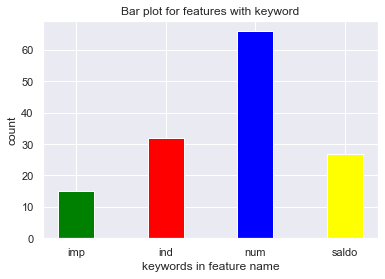

In [60]:
plt.bar(count_kw.keys(), count_kw.values(),width = 0.4,color=['Green', 'Red', 'blue', 'yellow'])
plt.xlabel('keywords in feature name')
plt.ylabel('count')
plt.title('Bar plot for features with keyword')
plt.show()

We have the maximum count for features with num keyword and the least is for keyword with imp

### 1. 'imp' keyword features

In [61]:
imp_kw = [i for i in X.columns if 'imp' in i ]
print(f"We have total {len(imp_kw)} features with 'imp' in its name")

We have total 15 features with 'imp' in its name


In [62]:
X[imp_kw].dtypes ## we can we that all columns are numerical features

imp_ent_var16_ult1           float64
imp_op_var39_comer_ult1      float64
imp_op_var39_comer_ult3      float64
imp_op_var41_comer_ult1      float64
imp_op_var41_comer_ult3      float64
imp_op_var41_efect_ult1      float64
imp_op_var41_efect_ult3      float64
imp_op_var41_ult1            float64
imp_op_var39_efect_ult1      float64
imp_op_var39_efect_ult3      float64
imp_op_var39_ult1            float64
delta_imp_aport_var13_1y3    float64
imp_aport_var13_hace3        float64
imp_var43_emit_ult1          float64
imp_trans_var37_ult1         float64
dtype: object

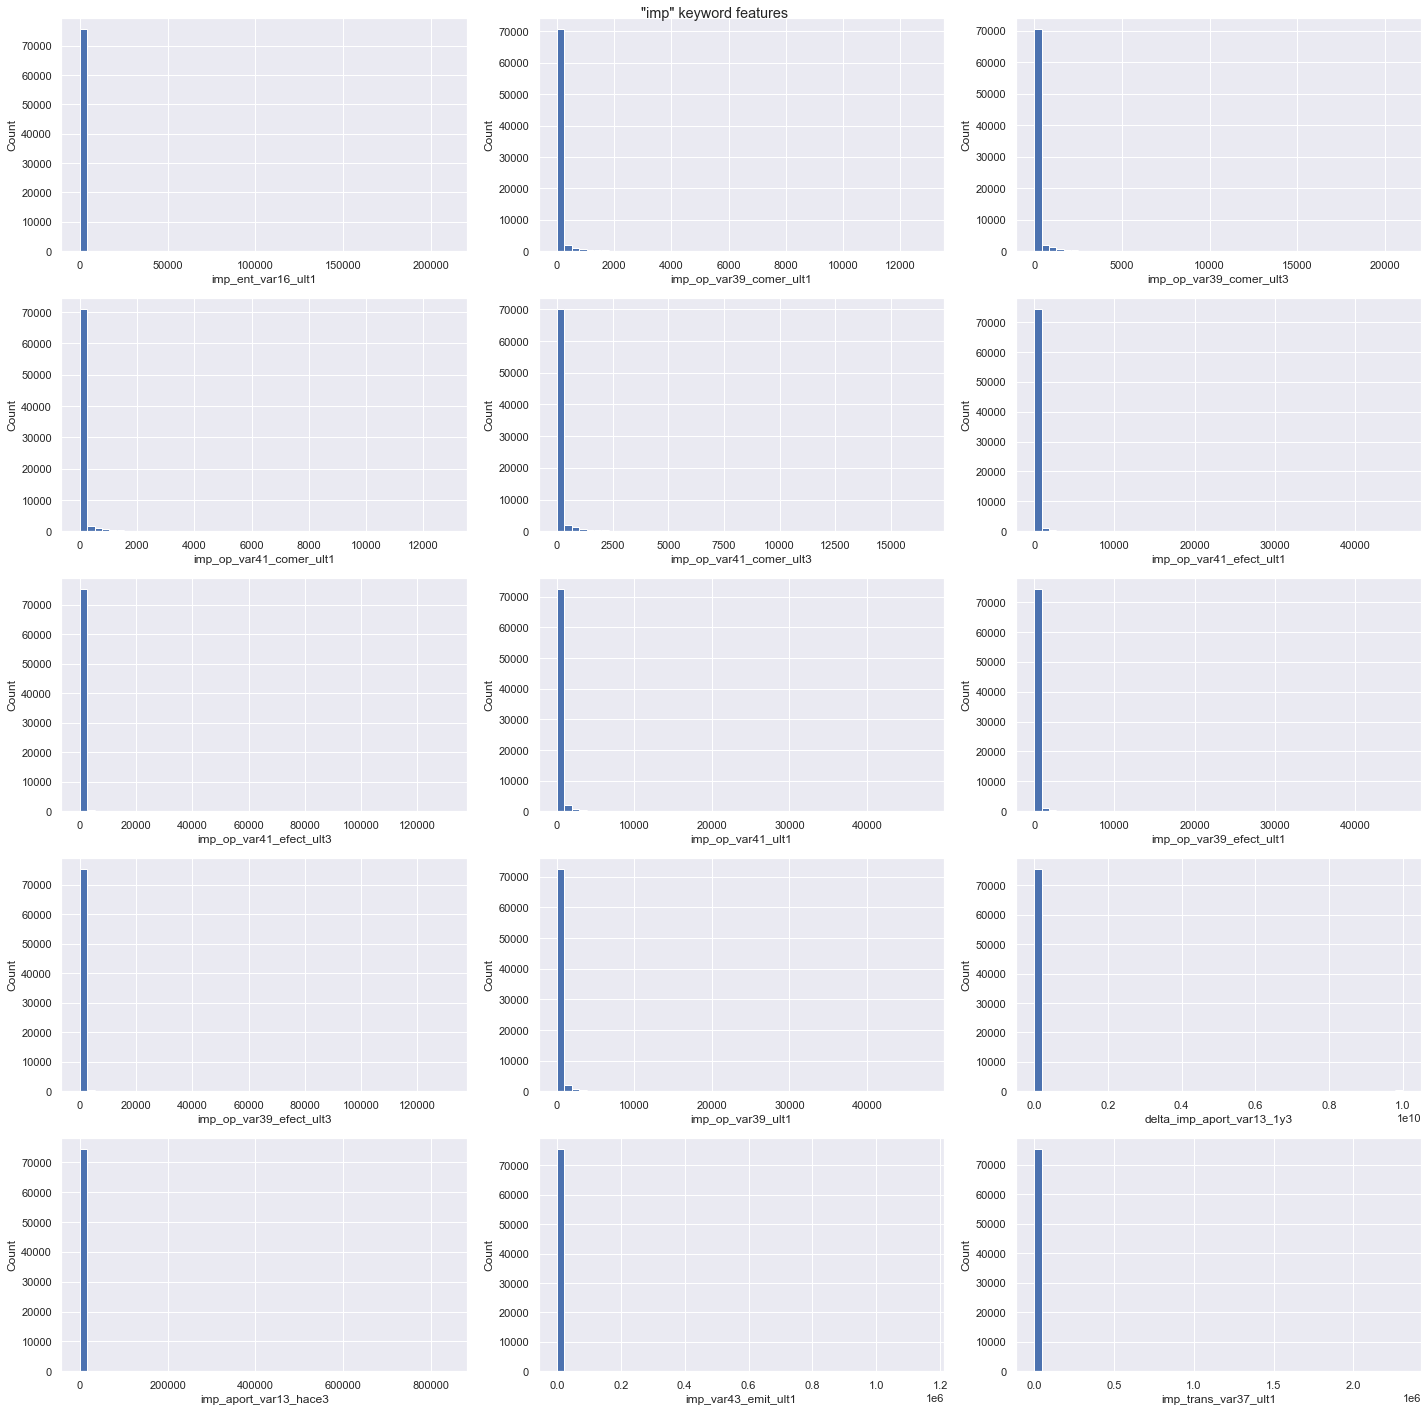

In [63]:
fig, axes = plt.subplots(5,3, figsize=(20, 20))
fig.suptitle('"imp" keyword features')
i=0
for x in range(5):
    for y in range(3):
        axes[x,y].hist(df[imp_kw[i]],50)
        axes[x,y].set(ylabel='Count', xlabel=imp_kw[i])
        i+=1
plt.tight_layout()

Here we can see that for all the features we have a high concentration of count at 0. We can try plotting the countplot again but removing this high concentration at 0.

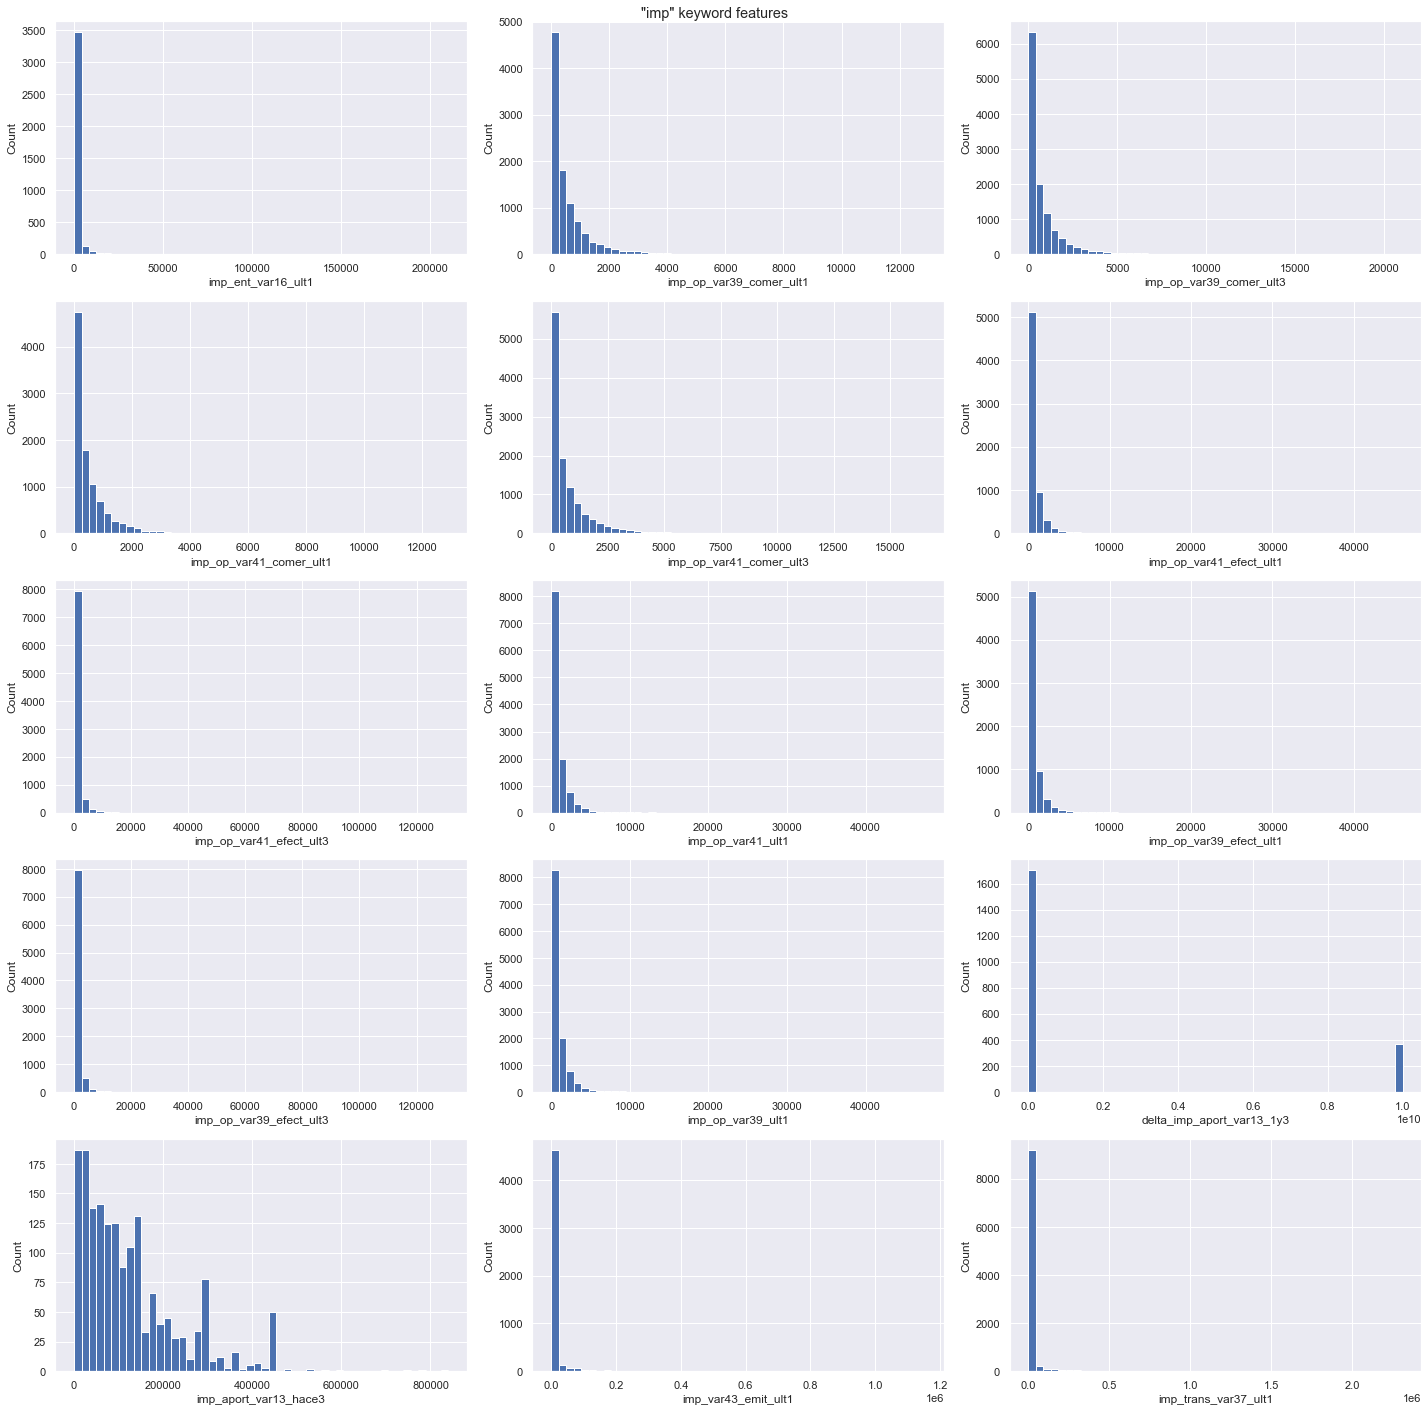

In [64]:
fig, axes = plt.subplots(5,3, figsize=(20, 20))
fig.suptitle('"imp" keyword features')
i=0
for x in range(5):
    for y in range(3):
        axes[x,y].hist(df[df[imp_kw[i]]!=0][imp_kw[i]],50) ## not using where the value is 0
        axes[x,y].set(ylabel='Count', xlabel=imp_kw[i])
        i+=1
plt.tight_layout()

We can see that for most of the transformation we have pareto like distribution and we can try taking log on these values and analyze further that if we get gausian like tranforms

C:\Users\ud231\miniconda3\envs\uohproject\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


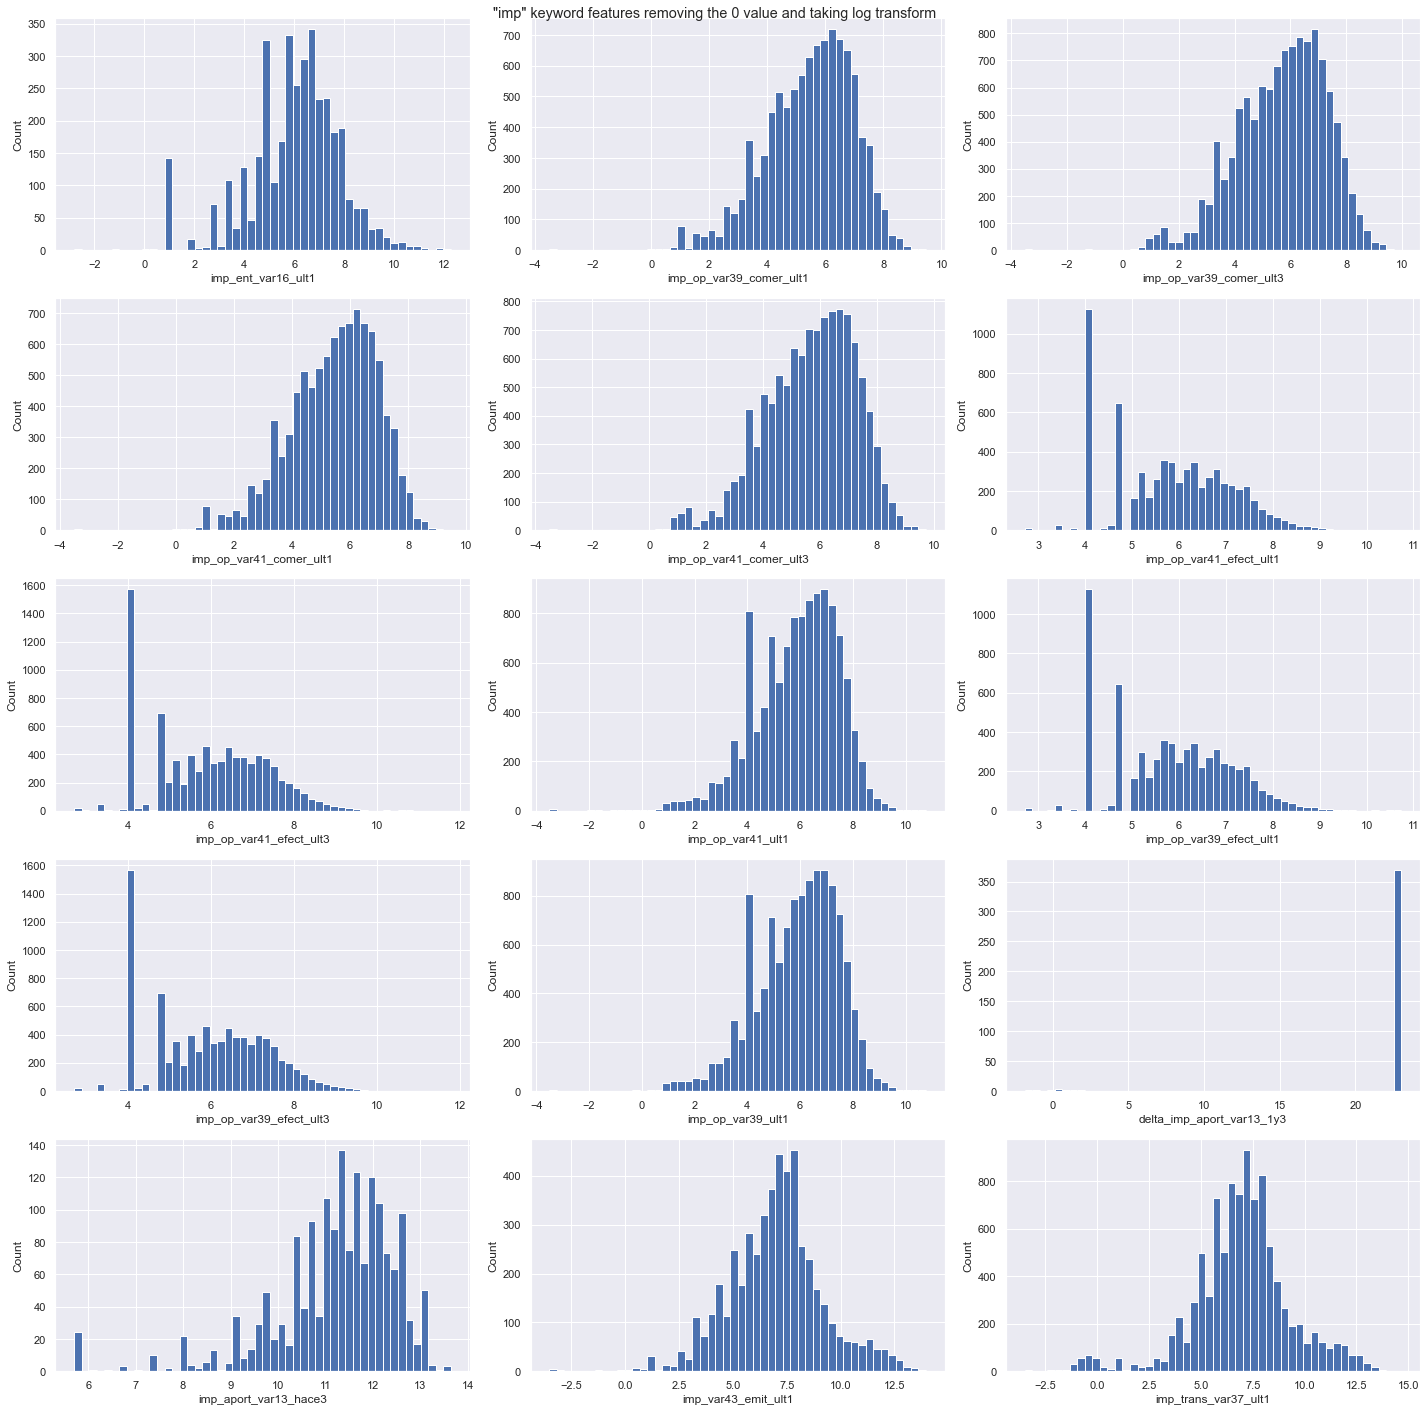

In [65]:
fig, axes = plt.subplots(5,3, figsize=(20, 20))
fig.suptitle('"imp" keyword features removing the 0 value and taking log transform')
i=0
for x in range(5):
    for y in range(3):
        axes[x,y].hist(np.log(df[df[imp_kw[i]]!=0][imp_kw[i]]),50)
        axes[x,y].set(ylabel='Count', xlabel=imp_kw[i])
        i+=1
plt.tight_layout()

This gives us a decent gausian distribution, expect maybe for the 'delta_imp_aport_var13_1y3', hence as a final transformation I will suggest to do log transformation for all the data

### 2. 'ind' keyword

In [66]:
ind_kw = [i for i in X.columns if 'ind' in i ]
print(f"We have total {len(ind_kw)} features with 'ind' in its name")

We have total 32 features with 'ind' in its name


In [67]:
X[ind_kw].dtypes ## we can we that all columns are categorical features

ind_var1_0              int64
ind_var5_0              int64
ind_var5                int64
ind_var8_0              int64
ind_var8                int64
ind_var12_0             int64
ind_var12               int64
ind_var13_0             int64
ind_var13_corto_0       int64
ind_var13_corto         int64
ind_var13_largo_0       int64
ind_var13_largo         int64
ind_var13               int64
ind_var14_0             int64
ind_var24_0             int64
ind_var24               int64
ind_var25_cte           int64
ind_var26_cte           int64
ind_var26               int64
ind_var25               int64
ind_var30               int64
ind_var37_cte           int64
ind_var37               int64
ind_var39_0             int64
ind_var40_0             int64
ind_var41_0             int64
ind_var10_ult1          int64
ind_var10cte_ult1       int64
ind_var9_cte_ult1       int64
ind_var9_ult1           int64
ind_var43_emit_ult1     int64
ind_var43_recib_ult1    int64
dtype: object

I can see that these variables are categorical with only cardinality of only 2 each feature in both classes

In [68]:
## showing just 10 features for the purpose of understanding
for i in ind_kw[0:10]:
    print('-'*50)
    print(f"Detail percentage of {i.upper()} for both classes")
    print('-'*50)
    dist_in_each_class(df, i)
    print()

--------------------------------------------------
Detail percentage of IND_VAR1_0 for both classes
--------------------------------------------------
**************************************************
For Satisfied Customers:
------------------------
0 = 98.86% of total Satisfied Customers
1 = 1.14% of total Satisfied Customers
**************************************************
For Unsatisfied Customers:
--------------------------
0 = 98.77% of total Unsatisfied Customers
1 = 1.23% of total Unsatisfied Customers
**************************************************

--------------------------------------------------
Detail percentage of IND_VAR5_0 for both classes
--------------------------------------------------
**************************************************
For Satisfied Customers:
------------------------
1 = 95.94% of total Satisfied Customers
0 = 4.06% of total Satisfied Customers
**************************************************
For Unsatisfied Customers:
--------------------

I am planning to keep all these variables as it is without actually doing any transformation on them.

### 3. 'num' keyword

In [69]:
num_kw = [i for i in X.columns if 'num' in i ]
print(f"We have total {len(num_kw)} features with 'num' in its name")

We have total 66 features with 'num' in its name


In [70]:
X[num_kw].dtypes ## we can we that all columns are numerical features

num_var1_0              int64
num_var4                int64
num_var5_0              int64
num_var5                int64
num_var8_0              int64
                        ...  
num_trasp_var11_ult1    int64
num_var45_hace2         int64
num_var45_hace3         int64
num_var45_ult1          int64
num_var45_ult3          int64
Length: 66, dtype: object

There was a observation I found for 59 features with keyword 'num' out of the 66 total. <br>The observation is as following:<b> All the possible values of the feature were a multiple of 3</b>

In [71]:
z=[]
for col in num_kw:
    a=[]
    for i in df[col].value_counts().index[:50]:
        if i!=0:
            a.append(i%3)
    if len(set(a))==1:
        z.append(col)

In [72]:
print(z)

['num_var1_0', 'num_var5_0', 'num_var5', 'num_var8_0', 'num_var8', 'num_var12_0', 'num_var12', 'num_var13_0', 'num_var13_corto_0', 'num_var13_corto', 'num_var13_largo_0', 'num_var13_largo', 'num_var13', 'num_var14_0', 'num_var24_0', 'num_var24', 'num_var26', 'num_var25', 'num_op_var41_hace2', 'num_op_var41_hace3', 'num_op_var41_ult1', 'num_op_var41_ult3', 'num_op_var39_hace2', 'num_op_var39_hace3', 'num_op_var39_ult1', 'num_op_var39_ult3', 'num_var30_0', 'num_var30', 'num_var35', 'num_var37_med_ult2', 'num_var37', 'num_var39_0', 'num_var40_0', 'num_var41_0', 'num_var42_0', 'num_var42', 'num_aport_var13_hace3', 'num_ent_var16_ult1', 'num_var22_hace2', 'num_var22_hace3', 'num_var22_ult1', 'num_var22_ult3', 'num_med_var22_ult3', 'num_med_var45_ult3', 'num_op_var39_comer_ult1', 'num_op_var39_comer_ult3', 'num_op_var41_comer_ult1', 'num_op_var41_comer_ult3', 'num_op_var41_efect_ult1', 'num_op_var41_efect_ult3', 'num_op_var39_efect_ult1', 'num_op_var39_efect_ult3', 'num_var43_emit_ult1', 'nu

If I take for example num_var42 we can see that the possible values of num_var42 features are all multiple of '3'

In [73]:
print(df.num_var42.value_counts().index.to_list())

[3, 0, 6, 9, 12, 15, 18]


another value we can check is num_var43_recib_ult1

In [74]:
print(df.num_var43_recib_ult1.value_counts().index.to_list())

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 45, 51, 48, 42, 54, 63, 66, 69, 84, 93, 78, 60, 90, 150, 57, 102, 108, 105, 75, 159, 96, 126, 72, 264]


<b>So I came up with another feature that we can make, a feature which is the count of features values in features with keyword 'num' which are multiple of 3 (by row).</b>

In [75]:
X['num_divide_by_3']=((X[num_kw]%3==0) & (X[num_kw]!=0)).astype(int).sum(axis=1)

In [76]:
## find the cardinality of the different 'num' keyword columns
cardinality_count=dict(zip(X[num_kw].columns, np.zeros(len(X[num_kw].columns))))
for col in X[num_kw].columns:
    cardinality_count[col]=len(X[col].value_counts())

In [77]:
cardi_list=[]
for f,c in zip(cardinality_count.keys(),cardinality_count.values()):
    cardi_list.append([f,c])
print("These are the feature and their cardinality.\n")
print(tabulate(cardi_list, headers=['Feature','Cardinality'], tablefmt="pretty"))

These are the feature and their cardinality.

+----------------------------+-------------+
|          Feature           | Cardinality |
+----------------------------+-------------+
|         num_var1_0         |      3      |
|          num_var4          |      8      |
|         num_var5_0         |      5      |
|          num_var5          |      5      |
|         num_var8_0         |      3      |
|          num_var8          |      2      |
|        num_var12_0         |      6      |
|         num_var12          |      4      |
|        num_var13_0         |      7      |
|     num_var13_corto_0      |      3      |
|      num_var13_corto       |      3      |
|     num_var13_largo_0      |      7      |
|      num_var13_largo       |      7      |
|         num_var13          |      7      |
|        num_var14_0         |      5      |
|        num_var24_0         |      4      |
|         num_var24          |      3      |
|         num_var26          |      9      |
|        

We can see that cardinality of the features are very large going to max of 172, having such high cardinality can result in high dimensional feature space after something like one hot encoding. So its better to reduce this feature space like considering only the top 75% values for feature and group rest in others. Doing so we can drastically reduce the feature space. 

Concept taken from this blog
https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b 

In [78]:
from collections import Counter
def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value=int(threshold*len(column))
    #Initialise an empty list for our new minimised categories
    categories_list=[]
    #Initialise a variable to calculate the sum of frequencies
    s=0
    #Create a counter dictionary of the form unique_value: frequency
    counts=Counter(column)

    #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s+=dict(counts)[i]
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s>=threshold_value:
            break
    #Append the category Other to the list
    categories_list.append('Other')

    #Replace all instances not in our new categories by Other  
    new_column=column.apply(lambda x: str(x) if x in categories_list else 'Other')

    #Return transformed column and unique values if return_categories=True
    if(return_categories_list):
        return new_column,categories_list
        #Return only the transformed column if return_categories=False
    else:
        return new_column

Test on this feature to show usage:

In [79]:
#Call the function with a default threshold of 75%
transformed_column,new_category_list=cumulatively_categorise(df['num_var45_ult3'],return_categories_list=True)
print(f"Cardinality reduced from {len(df['num_var45_ult3'].unique())} to {len(transformed_column.unique())}")

Cardinality reduced from 172 to 6


### 4. slado keyword

In [80]:
saldo_kw = [i for i in X.columns if 'saldo' in i ]
print(f"We have total {len(saldo_kw)} features with 'saldo' in its name")

We have total 27 features with 'saldo' in its name


In [81]:
X[saldo_kw].dtypes ## we can we that all columns are numerical features

saldo_var5                       float64
saldo_var8                       float64
saldo_var12                      float64
saldo_var13_corto                float64
saldo_var13_largo                float64
saldo_var13                      float64
saldo_var24                      float64
saldo_var26                      float64
saldo_var25                      float64
saldo_var30                      float64
saldo_var37                      float64
saldo_var42                      float64
saldo_medio_var5_hace2           float64
saldo_medio_var5_hace3           float64
saldo_medio_var5_ult1            float64
saldo_medio_var5_ult3            float64
saldo_medio_var8_hace2           float64
saldo_medio_var8_ult1            float64
saldo_medio_var8_ult3            float64
saldo_medio_var12_hace2          float64
saldo_medio_var12_hace3          float64
saldo_medio_var12_ult1           float64
saldo_medio_var12_ult3           float64
saldo_medio_var13_corto_hace2    float64
saldo_medio_var1

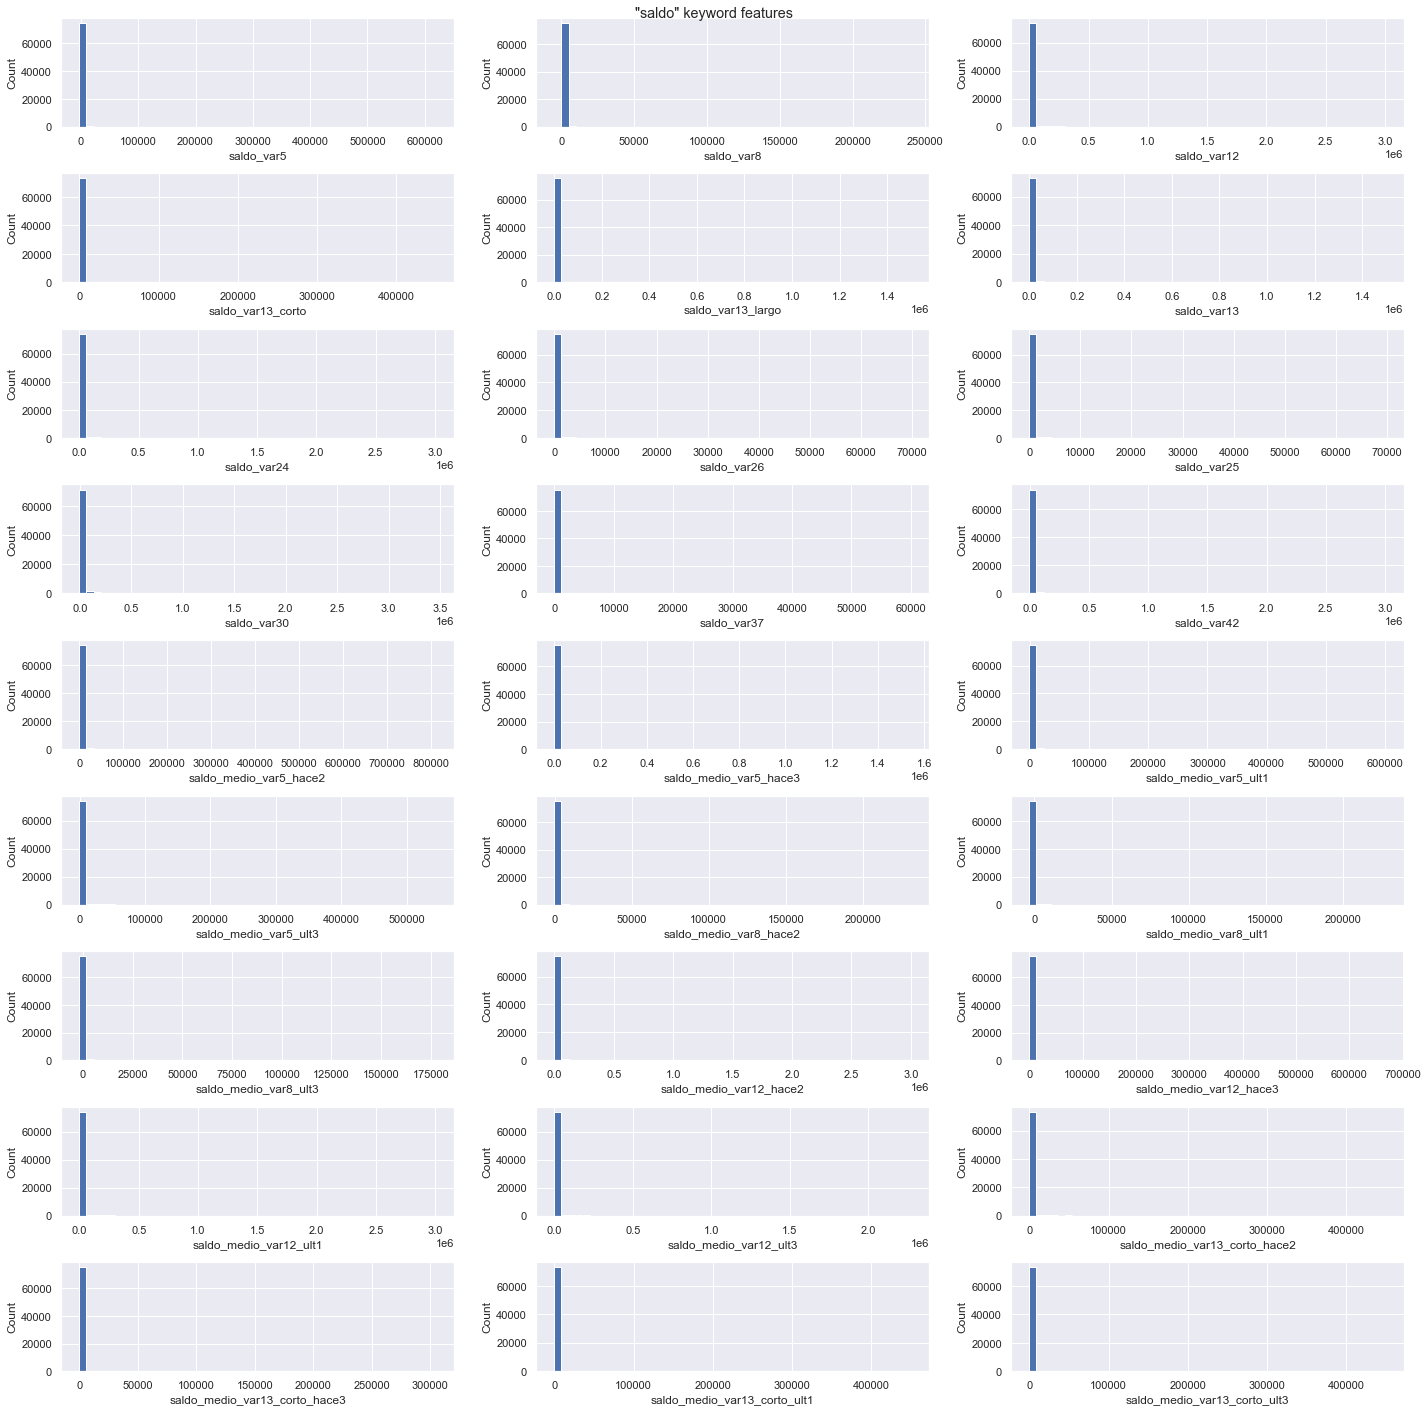

In [82]:
fig, axes = plt.subplots(9,3, figsize=(20, 20))
fig.suptitle('"saldo" keyword features')
i=0
for x in range(9):
    for y in range(3):
        axes[x,y].hist(df[saldo_kw[i]],50)
        axes[x,y].set(ylabel='Count', xlabel=saldo_kw[i])
        i+=1
plt.tight_layout()

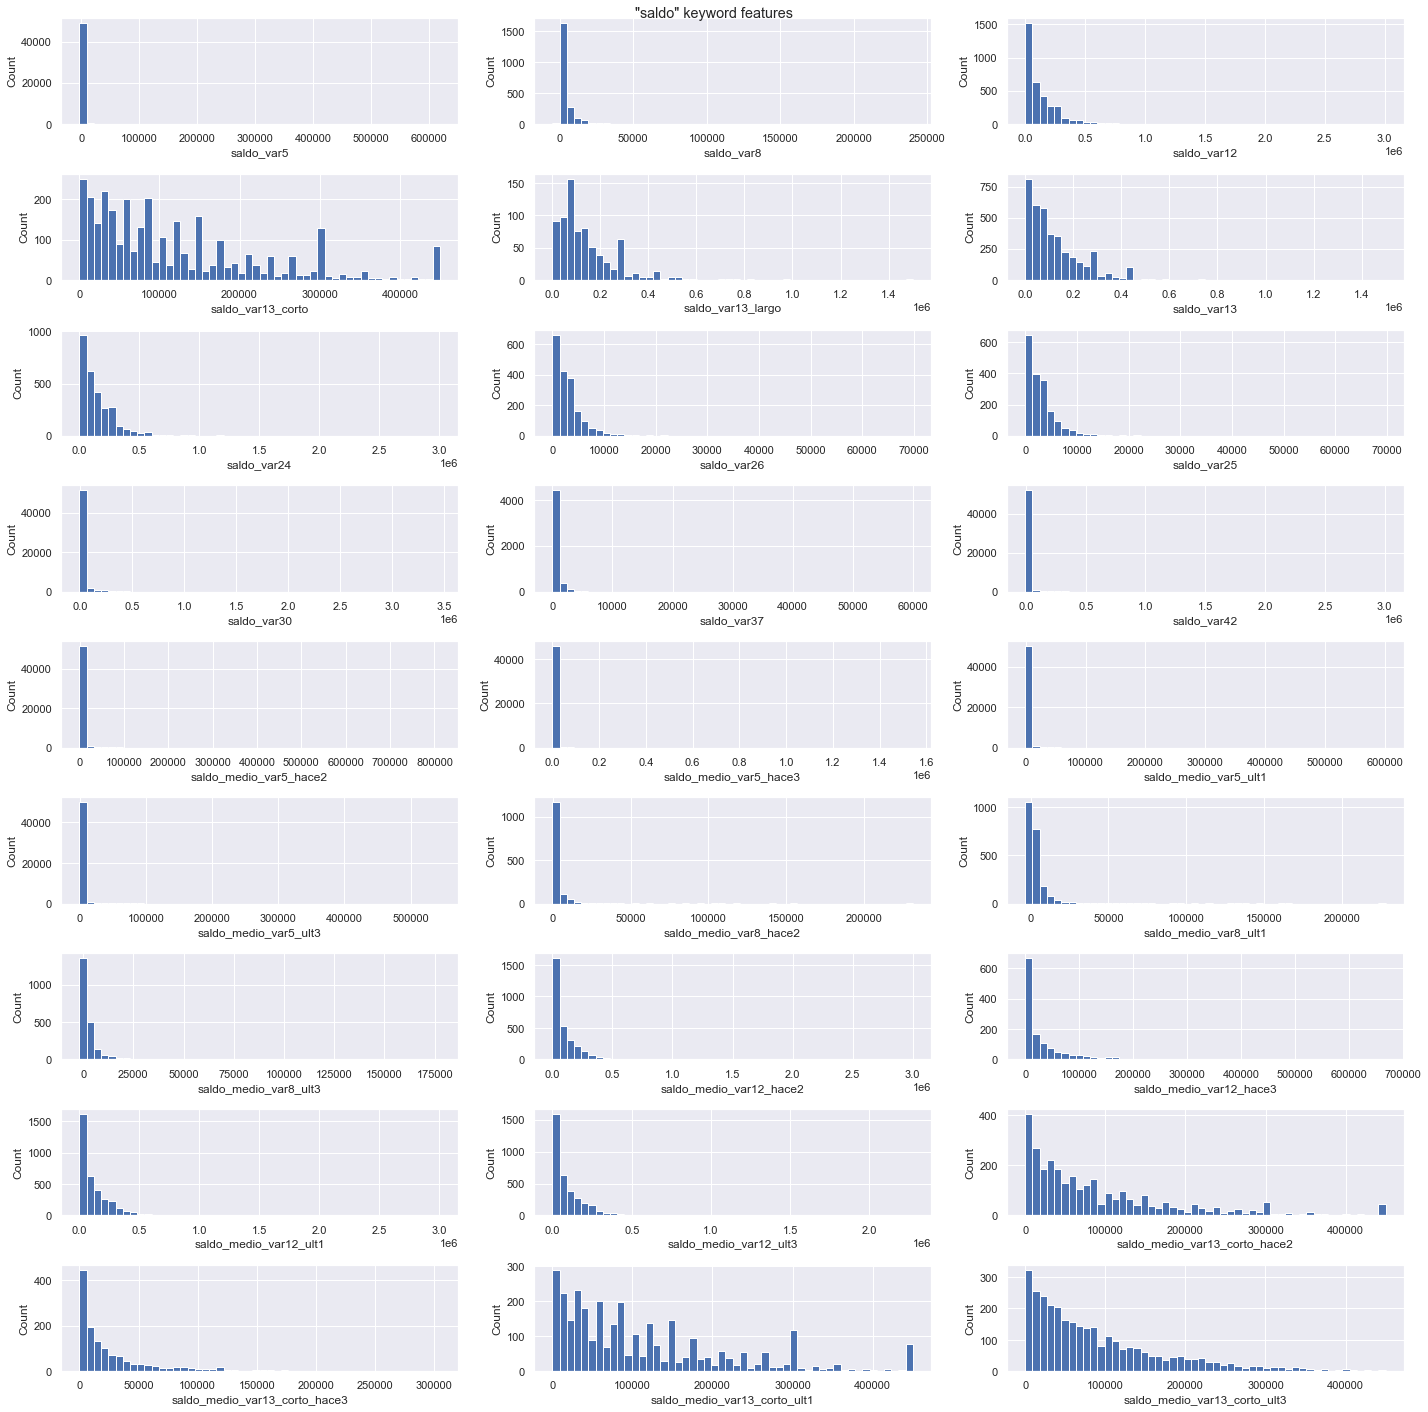

In [83]:
fig, axes = plt.subplots(9,3, figsize=(20, 20))
fig.suptitle('"saldo" keyword features')
i=0
for x in range(9):
    for y in range(3):
        axes[x,y].hist(df[df[saldo_kw[i]]!=0][saldo_kw[i]],50) ## not using where the value is 0
        axes[x,y].set(ylabel='Count', xlabel=saldo_kw[i])
        i+=1
plt.tight_layout()

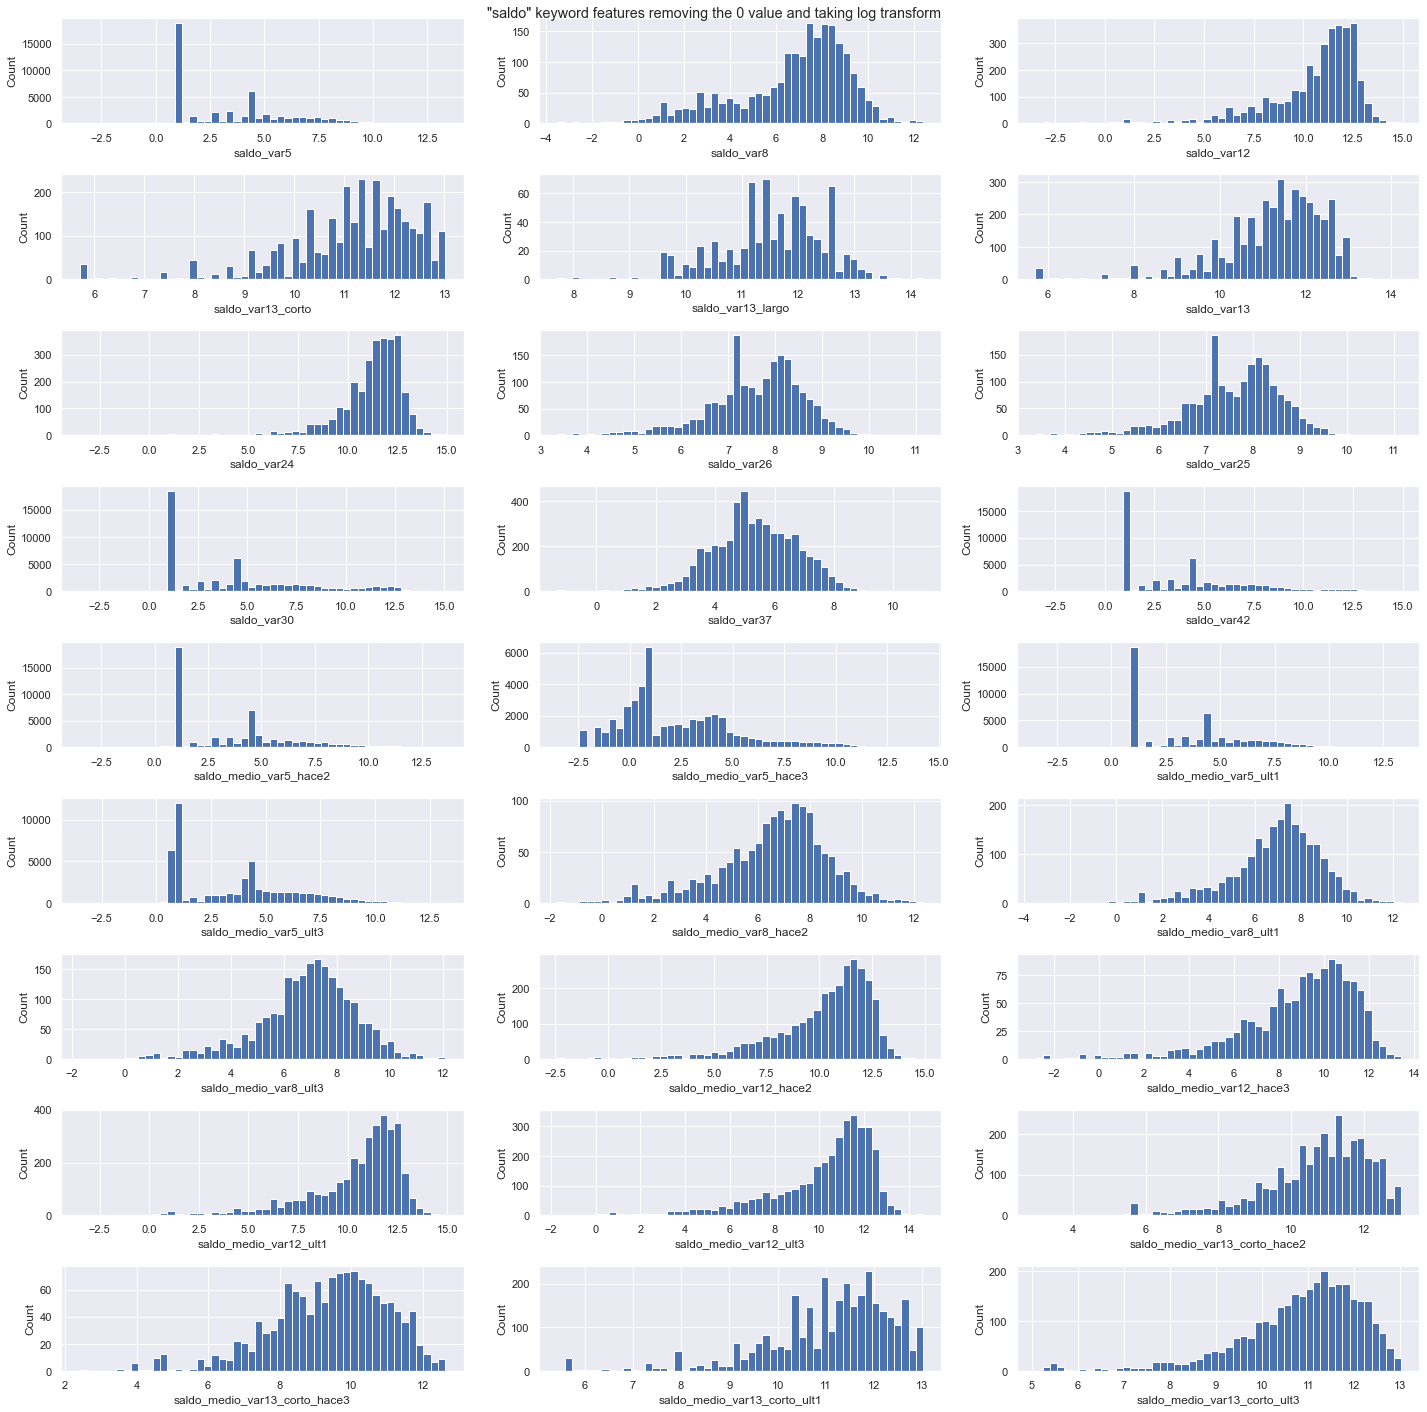

In [84]:
fig, axes = plt.subplots(9,3, figsize=(20, 20))
fig.suptitle('"saldo" keyword features removing the 0 value and taking log transform')
i=0
for x in range(9):
    for y in range(3):
        axes[x,y].hist(np.log(df[df[saldo_kw[i]]!=0][saldo_kw[i]]),50)
        axes[x,y].set(ylabel='Count', xlabel=saldo_kw[i])
        i+=1
plt.tight_layout()

This gives us a decent gausian distribution hence as a final transformation I will suggest to do log transformation for all the data similar to the imp keyword features.

### Correlated features

We want to remove the features which are highly correlated to each other.

<AxesSubplot:>

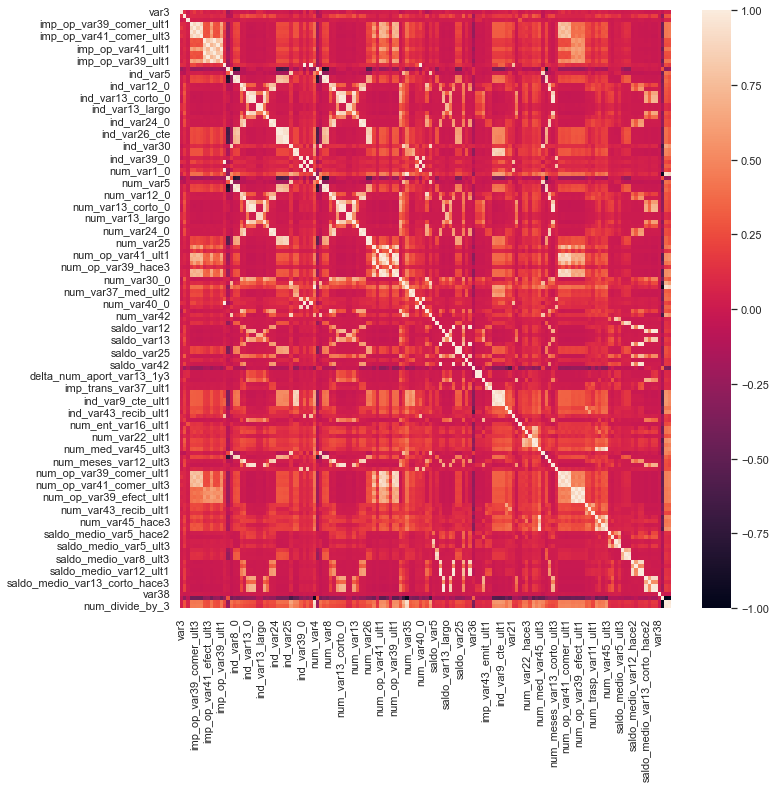

In [85]:
corrmat = X.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat)

DropCorrelatedFeatures() finds and removes correlated features. DropCorrelatedFeatures() works only with numerical variables. Categorical variables will need to be encoded to numerical or will be excluded from the analysis.

In [86]:
correlated = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.955) 
correlated.fit(X)

DropCorrelatedFeatures(threshold=0.955)

In [87]:
print('Number of variables before removing correlated: ', X.shape[1])

X = correlated.transform(X)

print('Number of variables after removing correlated: ', X.shape[1])

Number of variables before removing correlated:  148
Number of variables after removing correlated:  100


## Feature Engineering

#### 1. age of customers below 23

In [88]:
X['age_less_than_23']=[1 if i<23 else 0 for i in X.var15]

#### 2. var38 value is mode or not

In [89]:
X['var38_mode_val']=[1 if i==117310.979016494 else 0 for i in X.var38]

#### 3. take log of var38

In [90]:
X['var38']=np.log(X.var38)

To keep the information of missing value or an outlier like 99 or -999999 I have added these two new features:

#### 4. new feature to store if  we had -999999 as value in var3

In [91]:
X['var3_is_999999']=[1 if i==-999999 else 0 for i in df.var3]

#### 5. new feature to store if  we had 99 as value in var36

In [92]:
X['var36_is_99']=[1 if i==99 else 0 for i in df.var36]

#### 6. var21 is 0 or not

In [93]:
X['var21_is_0']=[1 if i==0 else 0 for i in df.var21]

#### 7. Kmean clusters

In [94]:
cols=X.columns
sc=sklearn.preprocessing.StandardScaler()
X_copy=X.copy()
X_copy.loc[:,cols]= sc.fit_transform(X_copy.loc[:,cols])
k=[2,4,6,8,10]

for n in k:
    f_name='K-mean-cluster-'+str(n)
    print(f"Doing for {f_name}")
    kmeans = KMeans(n_clusters=n,random_state=42)
    X[f_name] = kmeans.fit_predict(X_copy)

Doing for K-mean-cluster-2
Doing for K-mean-cluster-4
Doing for K-mean-cluster-6
Doing for K-mean-cluster-8
Doing for K-mean-cluster-10


### 8. Take log transformation

In [95]:
def apply_log(data,columns):
    """
    apply log transformation to all features in col variable
    """
    tr = data.copy()
    for col in columns:
        tr[col]=[np.log(i) if i > 0 else i for i in X[col]]
    return tr

features = [i for i in X.columns if (('saldo' in i)|('imp' in i)|(i=='var38'))&((X[i].values>=0).all())]
X=apply_log(X,features)

In [96]:
X.shape

(76020, 110)

### 9. One hot encoding

In [97]:
## get those features which have unique value less than 10 to encode and greater than 2
features_to_encode = []
for col in X.columns:
    if (X[col].nunique()<=10) & (col!='TARGET') & (X[col].nunique()>2) & ('K-mean' not in col):
        features_to_encode.append(col)

In [98]:
features_to_encode

['num_var4',
 'num_var5_0',
 'num_var12_0',
 'num_var13_largo_0',
 'num_var13',
 'num_var14_0',
 'num_var26',
 'num_var30',
 'num_var39_0',
 'num_var41_0',
 'num_var42_0',
 'num_var42',
 'var36',
 'num_aport_var13_hace3',
 'num_meses_var5_ult3',
 'num_meses_var8_ult3',
 'num_meses_var12_ult3',
 'num_meses_var39_vig_ult3']

In [99]:
len(features_to_encode)  ## length of categorical data according to our condition

18

In [100]:
## create one hot encoded object and fit on that categorical data
ohe = sklearn.preprocessing.OneHotEncoder(sparse=True,handle_unknown='ignore')
ohe.fit(X.loc[:,features_to_encode])

OneHotEncoder(handle_unknown='ignore')

In [101]:
ohe_array=ohe.transform(X[features_to_encode]).toarray()
new_feature_list=list(ohe.get_feature_names(input_features=features_to_encode))

In [102]:
encoded_df = pd.DataFrame(ohe_array,columns=new_feature_list)  ## make an encoded dataframe

In [103]:
X=pd.concat([X, encoded_df], axis=1)  ## concat the encoded data frame to original data frame

In [104]:
## next we remove the features that are now one hot encoded
for i in features_to_encode:
    X.drop(i,axis=1,inplace=True)

In [105]:
X.shape

(76020, 208)

### 10. Standardize the data

In [106]:
from sklearn.preprocessing import StandardScaler
standardized_X = StandardScaler().fit_transform(X)
print(standardized_X.shape)

(76020, 208)


## PCA and tsne representation of the data

shape of pca_reduced.shape =  (76020, 2)


C:\Users\ud231\miniconda3\envs\uohproject\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


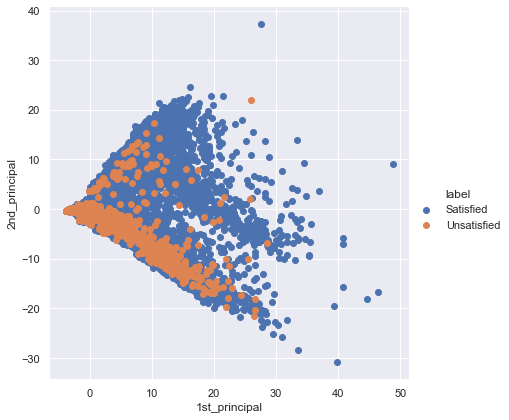

In [117]:
# initializing the pca
from sklearn import decomposition
pca = decomposition.PCA()
# configuring the parameteres
# the number of components = 2
pca.n_components = 2
pca_data = pca.fit_transform(standardized_X)

# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)
# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, df.TARGET)).T

# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sns.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

C:\Users\ud231\miniconda3\envs\uohproject\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


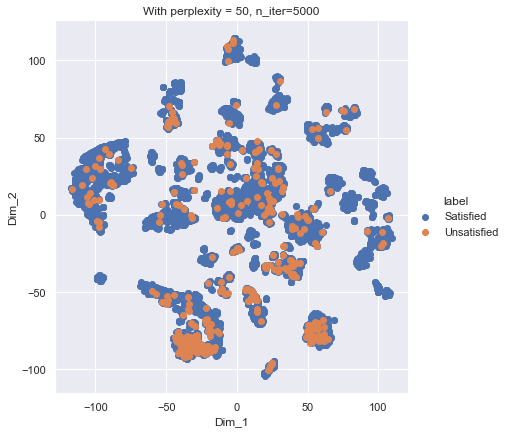

In [121]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000,n_jobs=-1)
tsne_data = model.fit_transform(standardized_X[:10000,:]) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, df.TARGET[0:10000])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, n_iter=5000')
plt.show()